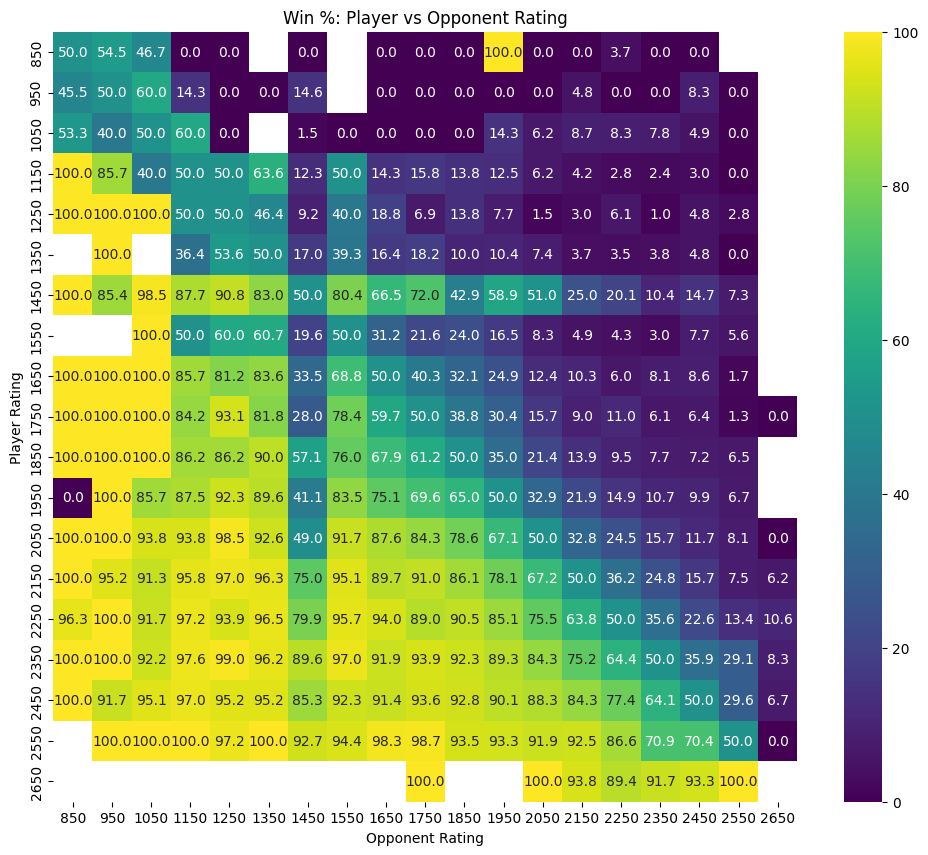

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load and clean data
data = pd.read_csv('lichess_games_data.csv')
data.dropna(inplace=True)

# numerical-ouput
def encode_winner(player_color, winner):
    if winner == player_color:
        return 1
    elif winner == 'draw':
        return 0.5
    return 0

# prep data simply
white_data = data.copy()
white_data['player_rating'] = white_data['white_rating']
white_data['opponent_rating'] = white_data['black_rating']
white_data['win_outcome'] = white_data.apply(lambda row: encode_winner('white', row['winner']), axis=1)
black_data = data.copy()
black_data['player_rating'] = black_data['black_rating']
black_data['opponent_rating'] = black_data['white_rating']
black_data['win_outcome'] = black_data.apply(lambda row: encode_winner('black', row['winner']), axis=1)

#combine+ filter draws
combined_data = pd.concat([white_data, black_data])
combined_data = combined_data[combined_data['win_outcome'] != 0.5]

# bin ratings and group
bins = np.arange(800, 2800, 100)
labels = bins[:-1] + 50
combined_data['player_rating_bin'] = pd.cut(combined_data['player_rating'], bins, labels=labels)
combined_data['opponent_rating_bin'] = pd.cut(combined_data['opponent_rating'], bins, labels=labels)

# pivot for the win percentages
win_table = combined_data.pivot_table('win_outcome', index='player_rating_bin', columns='opponent_rating_bin', aggfunc='mean', observed = False) * 100

# heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(win_table, annot=True, fmt=".1f", cmap='viridis')
plt.title('Win %: Player vs Opponent Rating')
plt.xlabel('Opponent Rating')
plt.ylabel('Player Rating')
plt.show()


data['rating_diff'] = data['white_rating'] - data['black_rating']

# Get win oucomes.
def encode_winner_simple(winner):
    if winner == 'white':
        return 1
    if winner == 'black':
        return 0
    return 0.5

data['win_outcome'] = data['winner'].apply(encode_winner_simple)

# win % grouped by diff bins
bins = np.arange(-1000, 1000, 50)
data['rating_diff_bin'] = pd.cut(data['rating_diff'], bins)
win_percentage = data.groupby('rating_diff_bin', observed=True)['win_outcome'].mean().reset_index()

# midpoints (grouping the categories of ratings)
win_percentage['rating_diff_mid'] = win_percentage['rating_diff_bin'].apply(lambda x: x.mid)





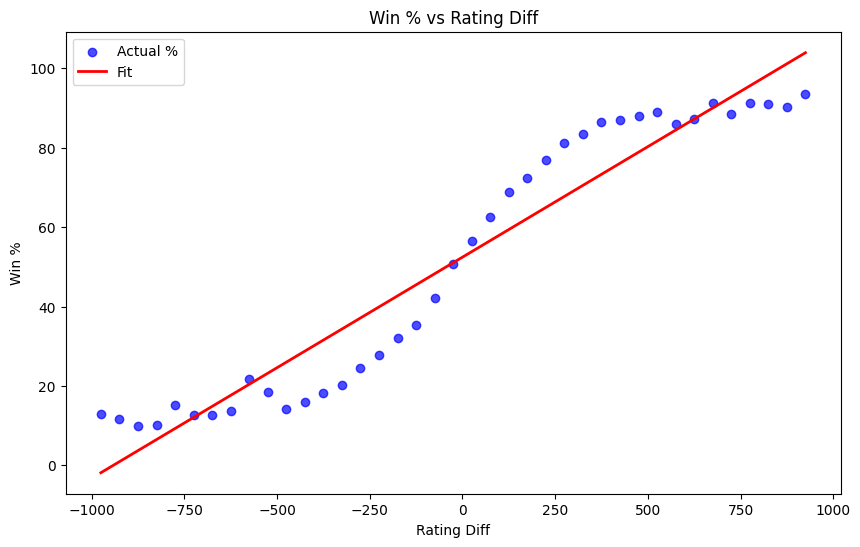

In [21]:
X = win_percentage['rating_diff_mid'].values
y = win_percentage['win_outcome'].values
X_b = np.c_[np.ones((len(X), 1)), X]
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
y_pred = X_b @ theta_best

# plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(X, y * 100, color='blue', alpha=0.7, label='Actual %')  # data points
plt.plot(X, y_pred * 100, color='red', linewidth=2, label='Fit')  #our regression line
plt.title('Win % vs Rating Diff')
plt.xlabel('Rating Diff')
plt.ylabel('Win %')
plt.legend()
plt.show()